In [57]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import seaborn as sb
import scipy
import time
from imblearn.over_sampling import SMOTE
import sklearn.gaussian_process as gp
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, matthews_corrcoef
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import lightgbm as lgb
import forestci

In [2]:
import tensorflow as tf

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
os.listdir('dataset')

['application_test.csv',
 'HomeCredit_columns_description.csv',
 'POS_CASH_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'application_train.csv',
 'bureau.csv',
 'previous_application.csv',
 'bureau_balance.csv',
 'sample_submission.csv']

In [4]:
dataset_test = pd.read_csv('dataset/application_test.csv')
dataset_train = pd.read_csv('dataset/application_train.csv')

In [5]:
dataset_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
dataset_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

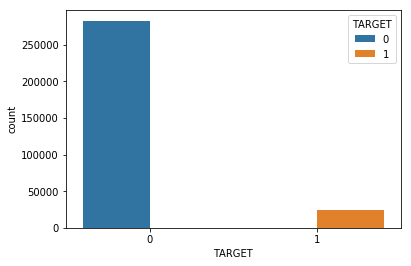

In [7]:
sb.countplot(x='TARGET',hue='TARGET',data=dataset_train)

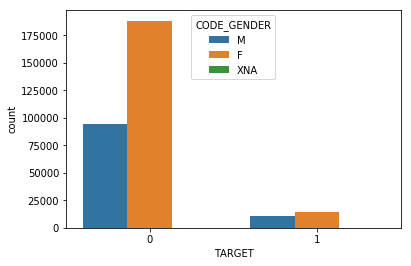

In [8]:
sb.countplot(x='TARGET',hue='CODE_GENDER',data=dataset_train)

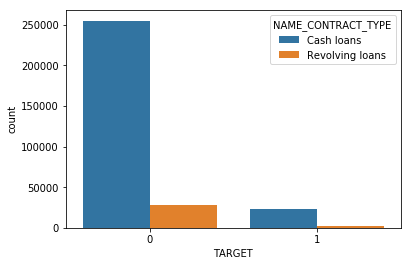

In [9]:
sb.countplot(x='TARGET',hue='NAME_CONTRACT_TYPE',data=dataset_train)

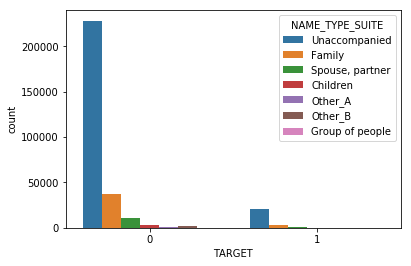

In [10]:
sb.countplot(x='TARGET',hue='NAME_TYPE_SUITE',data=dataset_train)

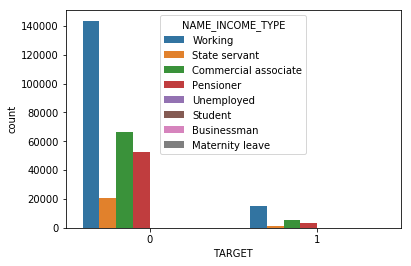

In [11]:
sb.countplot(x='TARGET',hue='NAME_INCOME_TYPE',data=dataset_train)

In [12]:
(dataset_train['DAYS_BIRTH']/-365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

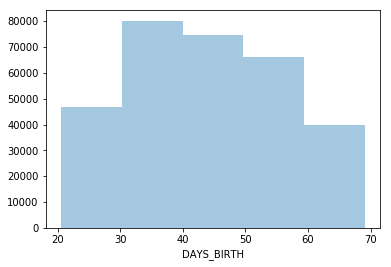

In [13]:
sb.distplot(dataset_train['DAYS_BIRTH']/-365,bins=5,kde=False)

In [14]:
len(dataset_train[dataset_train['DAYS_EMPLOYED'] > 0])

55374

In [15]:
(dataset_train[dataset_train['DAYS_EMPLOYED'] > 0]['TARGET'] == 1).value_counts()

False    52384
True      2990
Name: TARGET, dtype: int64

In [16]:
(abs(dataset_train['DAYS_EMPLOYED']/365)).describe()

count    307511.000000
mean        185.547239
std         382.037676
min           0.000000
25%           2.556164
50%           6.079452
75%          15.635616
max        1000.665753
Name: DAYS_EMPLOYED, dtype: float64

In [17]:
max(dataset_train['DAYS_EMPLOYED'])

365243

In [18]:
len(dataset_train['DAYS_EMPLOYED'] == 365243)

307511

In [19]:
dataset_train['EMP_AN'] = dataset_train['DAYS_EMPLOYED'] == 365243

In [20]:
dataset_train['DAYS_EMPLOYED'] = dataset_train['DAYS_EMPLOYED'].replace({365243: np.nan})

In [21]:
(abs(dataset_train['DAYS_EMPLOYED']/365)).describe()

count    252137.000000
mean          6.531971
std           6.406466
min           0.000000
25%           2.101370
50%           4.515068
75%           8.698630
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

In [22]:
(abs(dataset_train['DAYS_REGISTRATION']/365)).describe()

count    307511.000000
mean         13.660604
std           9.651743
min           0.000000
25%           5.506849
50%          12.339726
75%          20.491781
max          67.594521
Name: DAYS_REGISTRATION, dtype: float64

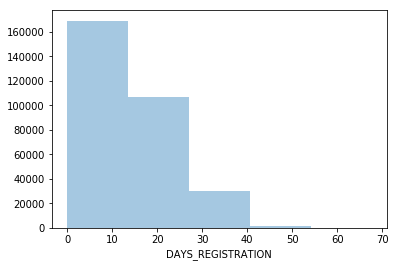

In [23]:
sb.distplot(dataset_train['DAYS_REGISTRATION']/-365,bins=5,kde=False)

In [24]:
len(dataset_train[dataset_train['DAYS_REGISTRATION']/-365 > 50]['DAYS_BIRTH']/-365 > 50)

80

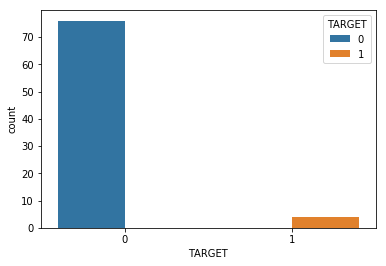

In [25]:
sb.countplot(x='TARGET',hue='TARGET',data=dataset_train[dataset_train['DAYS_REGISTRATION']/-365 > 50])

In [26]:
dataset_train = dataset_train.drop(dataset_train[dataset_train['DAYS_REGISTRATION']/-365 > 50].index,axis=0)

In [27]:
len(dataset_train[dataset_train['DAYS_REGISTRATION']/-365 > 50]['DAYS_BIRTH']/-365 > 50)

0

In [28]:
dataset_train.shape

(307431, 123)

In [29]:
corr = dataset_train.corr(method='pearson')

In [30]:
column_names = list(corr.columns.values)
columns_to_remove = []
for idx,row in corr.iterrows():
    for i in range(0,len(row)):
        if row[i] > 0.70:
            if idx != column_names[i] and idx not in columns_to_remove and column_names[i] not in columns_to_remove:
                columns_to_remove.append(idx)
                columns_to_remove.append(column_names[i])
                print(idx + " - " + column_names[i])
                print(row[i])

CNT_CHILDREN - CNT_FAM_MEMBERS
0.8791849055884082
AMT_CREDIT - AMT_ANNUITY
0.7701355325112837
REGION_RATING_CLIENT - REGION_RATING_CLIENT_W_CITY
0.9508244177203856
REG_REGION_NOT_WORK_REGION - LIVE_REGION_NOT_WORK_REGION
0.8606542659268078
REG_CITY_NOT_WORK_CITY - LIVE_CITY_NOT_WORK_CITY
0.8255558750839367
APARTMENTS_AVG - ELEVATORS_AVG
0.8369526900299763
BASEMENTAREA_AVG - BASEMENTAREA_MODE
0.973496185301789
YEARS_BEGINEXPLUATATION_AVG - YEARS_BEGINEXPLUATATION_MODE
0.97189305389083
YEARS_BUILD_AVG - YEARS_BUILD_MODE
0.9894360514168624
COMMONAREA_AVG - COMMONAREA_MODE
0.9771461116759385
ENTRANCES_AVG - ENTRANCES_MODE
0.9777417653401914
FLOORSMAX_AVG - FLOORSMIN_AVG
0.7424268126795673
LANDAREA_AVG - LANDAREA_MODE
0.9736925929909296
LIVINGAPARTMENTS_AVG - LIVINGAREA_AVG
0.8807913124080583
NONLIVINGAPARTMENTS_AVG - NONLIVINGAPARTMENTS_MODE
0.9693697425066614
NONLIVINGAREA_AVG - NONLIVINGAREA_MODE
0.9660854607189583
APARTMENTS_MODE - ELEVATORS_MODE
0.8262109330460732
FLOORSMAX_MODE - FLOO

In [31]:
#Columnd to remove die to high correlation (Only measured colinearity among pairs of parameters still have to deal
#with multi-colinearity)
columns_to_remove = ['CNT_CHILDREN','REGION_RATING_CLIENT_W_CITY','REG_REGION_NOT_WORK_REGION',
                    'LIVE_CITY_NOT_WORK_CITY','ELEVATORS_AVG','BASEMENTAREA_MODE','YEARS_BEGINEXPLUATATION_MODE',
                    'YEARS_BUILD_MODE','COMMONAREA_MODE','ENTRANCES_MODE','FLOORSMIN_AVG','LANDAREA_MODE',
                    'LIVINGAPARTMENTS_AVG','NONLIVINGAPARTMENTS_MODE','ELEVATORS_MODE','FLOORSMIN_MODE',
                    'LIVINGAREA_MODE','ELEVATORS_MEDI','FLOORSMIN_MEDI','LIVINGAREA_MEDI','OBS_60_CNT_SOCIAL_CIRCLE',
                    'DEF_60_CNT_SOCIAL_CIRCLE']

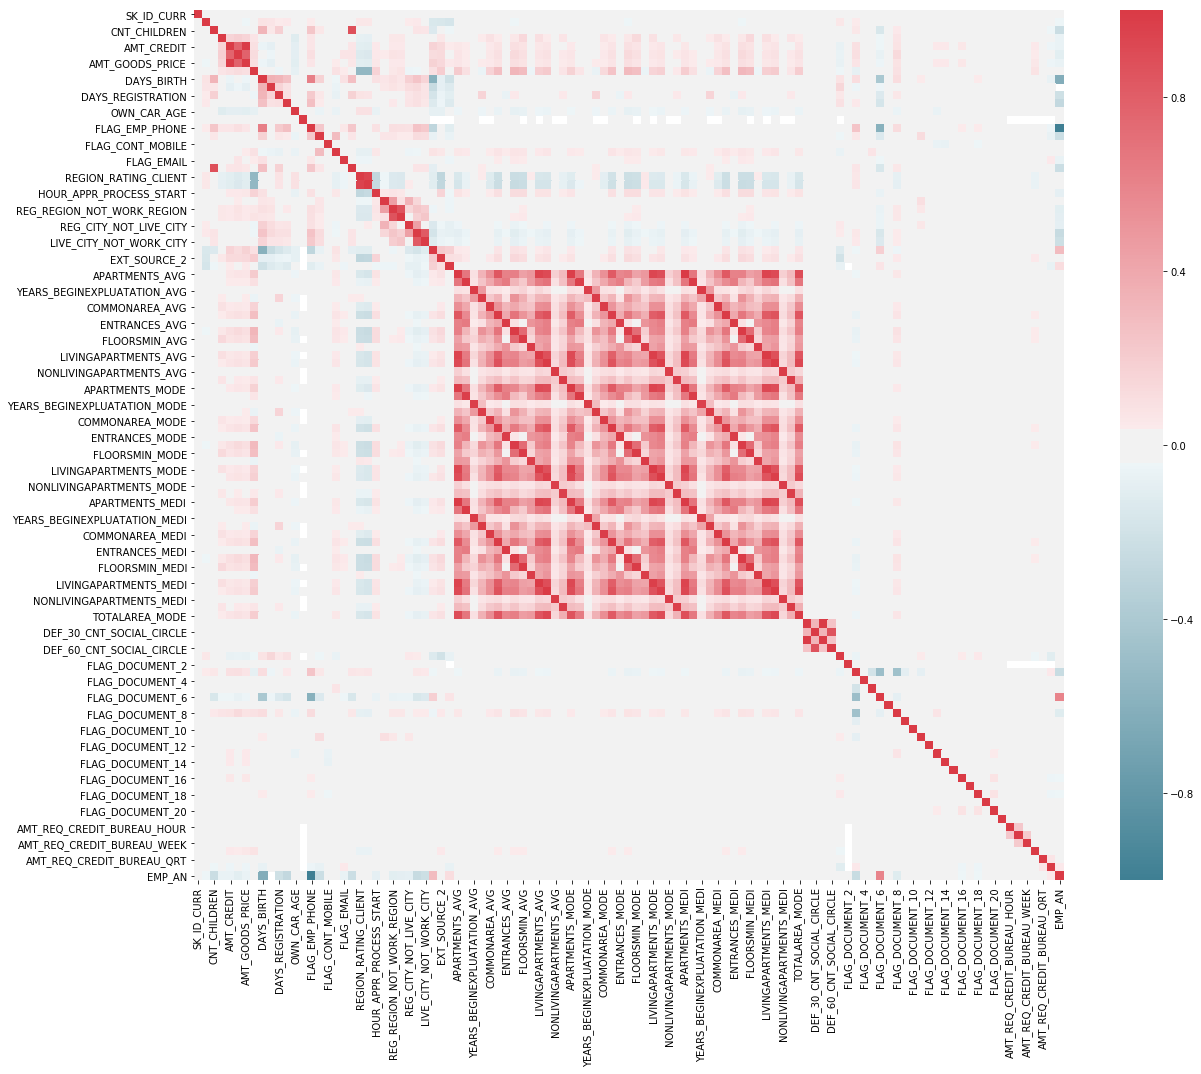

In [32]:
f,ax = plt.subplots(figsize=(20,16))
corr = dataset_train.corr()
corr_heatmap = sb.heatmap(corr,mask=np.zeros_like(corr,dtype=np.bool),cmap=sb.diverging_palette(220,10,as_cmap=True),square=True,ax=ax)
corr_figure = corr_heatmap.get_figure()
corr_figure.savefig("correlations_heatmap.png")

In [33]:
dataset_train = dataset_train.drop(columns_to_remove,axis=1)

In [34]:
dataset_train.select_dtypes('object').apply(pd.Series.nunique)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [35]:
columns_to_label_encode = ['NAME_CONTRACT_TYPE','FLAG_OWN_CAR',
                           'FLAG_OWN_REALTY','EMERGENCYSTATE_MODE']
starttime = time.time()
for column in columns_to_label_encode:
    le = LabelEncoder()
    dataset_train[column] = le.fit_transform(dataset_train[column].astype(str))
endtime = time.time()
print("Time Elapsed:- ")
print(endtime - starttime)

Time Elapsed:- 
0.30323100090026855


In [36]:
columns_to_one_hot_encode = ['CODE_GENDER','NAME_TYPE_SUITE','NAME_INCOME_TYPE',
                           'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE',
                             'OCCUPATION_TYPE','ORGANIZATION_TYPE','WEEKDAY_APPR_PROCESS_START',
                            'FONDKAPREMONT_MODE','WALLSMATERIAL_MODE','HOUSETYPE_MODE']
starttime = time.time()
for column in columns_to_one_hot_encode:
    le = LabelEncoder()
    oe = OneHotEncoder()
    label_encoded = le.fit_transform(dataset_train[column].astype(str))
    label_encoded = label_encoded.reshape(-1,1)
    one_hot_encoded = oe.fit_transform(label_encoded).toarray()
    df = pd.DataFrame(one_hot_encoded,columns=[column + str(i) for i in range(0,one_hot_encoded.shape[1])])
    df = df.drop([column + "0"],axis=1)
    dataset_train = pd.concat([dataset_train,df],axis=1)
    print(column + " - " + str(dataset_train.shape[0]) + " " + str(dataset_train.shape[1]))
dataset_train = dataset_train.drop(columns_to_one_hot_encode,axis=1)
dataset_train.shape

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


CODE_GENDER - 307511 103


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


NAME_TYPE_SUITE - 307511 110


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


NAME_INCOME_TYPE - 307511 118


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


NAME_EDUCATION_TYPE - 307511 123


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


NAME_FAMILY_STATUS - 307511 129


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


NAME_HOUSING_TYPE - 307511 135


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


OCCUPATION_TYPE - 307511 153


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


ORGANIZATION_TYPE - 307511 211


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


WEEKDAY_APPR_PROCESS_START - 307511 218


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


FONDKAPREMONT_MODE - 307511 222


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


WALLSMATERIAL_MODE - 307511 229


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


HOUSETYPE_MODE - 307511 232


(307511, 220)

In [37]:
dataset_train['DIR'] = dataset_train['AMT_CREDIT']/dataset_train['AMT_INCOME_TOTAL']
dataset_train['AIR'] = dataset_train['AMT_ANNUITY']/dataset_train['AMT_INCOME_TOTAL']
dataset_train['ACR'] = dataset_train['AMT_ANNUITY']/dataset_train['AMT_CREDIT']
dataset_train['DAR'] = dataset_train['DAYS_EMPLOYED']/dataset_train['DAYS_BIRTH']

In [38]:
#Using random under sampling to handle imbalanced dataset
under_sampled_dataset_train_0 = dataset_train[dataset_train.TARGET == 0].sample(40000)
under_sampled_dataset_train_1 = dataset_train[dataset_train.TARGET == 1].sample(20000)
dataset_train = pd.concat([under_sampled_dataset_train_0,under_sampled_dataset_train_1],ignore_index=True)

In [39]:
from sklearn.preprocessing import StandardScaler, Imputer
imputer = Imputer(strategy='median')
scaler = StandardScaler()
dataset_train_tr = imputer.fit_transform(dataset_train.drop(['SK_ID_CURR','TARGET'],axis=1))
dataset_train_tr = scaler.fit_transform(dataset_train_tr)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [40]:
X = dataset_train_tr
y = dataset_train['TARGET']

In [41]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=232)

In [42]:
X_test = pd.DataFrame(X_test,columns=dataset_train.columns.drop(['SK_ID_CURR','TARGET']))

In [43]:
X_test.shape

(12000, 222)

In [44]:
y_test.shape

(12000,)

Text(0.5,0.98,'Benchmark Data Resampled with SMOTE')

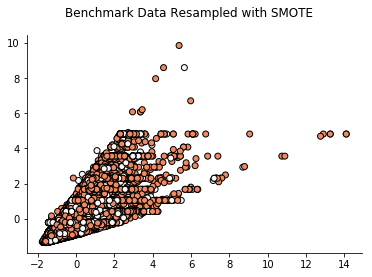

In [45]:
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_train]
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
plt.scatter(X_train[:, 5], X_train[:, 6], c=colors, **kwarg_params)
sb.despine()
plt.suptitle("Benchmark Data Resampled with SMOTE")

In [46]:
#Using SMOTE(Synthetic Minority Oversampling Technique) to handle imbalanced dataset
smote_train = SMOTE(random_state=232)
os_data_X,os_data_y = smote_train.fit_sample(X_train,y_train)
X_train = pd.DataFrame(data=os_data_X,columns=dataset_train.columns.drop(['SK_ID_CURR','TARGET']) )
y_train = pd.DataFrame(data=os_data_y,columns=["TARGET"])

Text(0.5,0.98,'Benchmark Data Resampled with SMOTE')

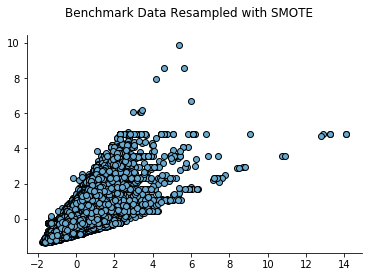

In [47]:
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_train]
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
plt.scatter(X_train.iloc[:, 5], X_train.iloc[:, 6], c=colors, **kwarg_params)
sb.despine()
plt.suptitle("Benchmark Data Resampled with SMOTE")

In [48]:
X_test.shape

(12000, 222)

In [49]:
y_test.shape

(12000,)

Text(0.5,0.98,'Benchmark Data Resampled with SMOTE')

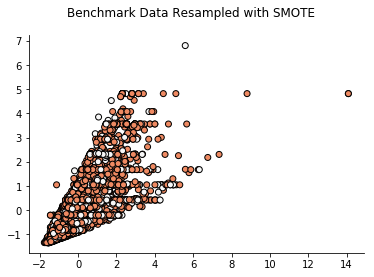

In [50]:
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_test]
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
plt.scatter(X_test.iloc[:, 5], X_test.iloc[:, 6], c=colors, **kwarg_params)
sb.despine()
plt.suptitle("Benchmark Data Resampled with SMOTE")

In [51]:
smote_test = SMOTE(random_state=232)
os_data_X,os_data_Y = smote_test.fit_sample(X_test,y_test)
X_test = pd.DataFrame(data=os_data_X,columns=dataset_train.columns.drop(['SK_ID_CURR','TARGET']))
y_test = pd.DataFrame(data=os_data_Y,columns=['TARGET'])

Text(0.5,0.98,'Benchmark Data Resampled with SMOTE')

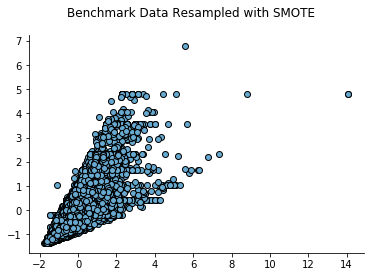

In [52]:
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_test]
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
plt.scatter(X_test.iloc[:, 5], X_test.iloc[:, 6], c=colors, **kwarg_params)
sb.despine()
plt.suptitle("Benchmark Data Resampled with SMOTE")

In [53]:
X_train.shape

(63824, 222)

In [54]:
y_train.shape

(63824, 1)

In [55]:
X_test.shape

(16176, 222)

In [56]:
y_test.shape

(16176, 1)

In [86]:
def generate_classifier_report(classifier,predictions,predictions_prob,name):
    print('Model stats for ' + name + ":")
    print('Accuracy:')
    print(accuracy_score(y_test,predictions))
    print('Confusion matrix:')
    print(confusion_matrix(y_test,predictions).ravel())
    print('Mathews correlation coefficient:')
    print(matthews_corrcoef(y_test,predictions))
    print('Classification report:')
    print(classification_report(y_test,predictions))
    logit_roc_score = roc_auc_score(y_test,predictions)
    fpr, tpr, thresholds = roc_curve(y_test,predictions_prob)
    plt.figure()
    plt.plot(fpr,tpr,label=name + " AUC score:- " + str(logit_roc_score))
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel('False Positive Rate (FP / (FP + TN))')
    plt.ylabel('True Positive Rate (TP / (TP + FN))')
    plt.title('Receiver Operating Characteristics Curve')
    plt.legend(loc="lower right")
    plt.savefig(name + "_roc_curve")
    plt.show()

In [59]:
X.shape

(60000, 222)

In [60]:
y.shape

(60000,)

In [61]:
X = pd.concat([X_train,X_test],axis=0)
y = pd.concat([y_train,y_test],axis=0)

In [62]:
y_train = np.array(y_train)
y_train = y_train.ravel()

In [63]:
y_test = np.array(y_test)
y_test = y_test.ravel()

In [64]:
y = np.array(y)
y = y.ravel()

In [65]:
def cross_validation_score(model,X,y,cv=5):
    scores = cross_val_score(model,X,y,cv=cv)
    return sum(scores)/len(scores)

In [67]:
clf = LogisticRegression(C=0.4,max_iter = 1000)
clf.fit(X_train,y_train)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.4, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [68]:
prediction = clf.predict(X_test)

In [69]:
cross_validation_score(clf,X,y,cv=5)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

0.6949875000000001

Model stats for logistic_regression:
Accuracy:
0.6933728981206726
Confusion matrix:
0.6933728981206726
Mathews correlation coefficient:
0.3867496273527029
Classification report:
              precision    recall  f1-score   support

         0.0       0.69      0.69      0.69      8088
         1.0       0.69      0.70      0.69      8088

   micro avg       0.69      0.69      0.69     16176
   macro avg       0.69      0.69      0.69     16176
weighted avg       0.69      0.69      0.69     16176



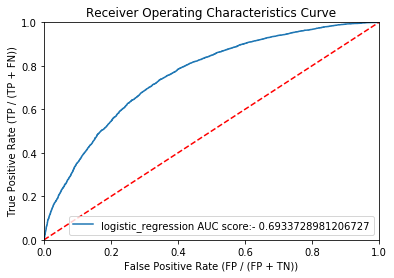

In [70]:
generate_classifier_report(clf,prediction,clf.predict_proba(X_test)[:,1],name="logistic_regression")

In [ ]:
starttime = time.time()
clf = SVC(gamma=0.001, C=1.0,probability=True,verbose=True)
clf.fit(X_train,y_train)
endtime = time.time()
print("Time to train SVC classifier:- ")
print(endtime - starttime)

In [ ]:
pred = clf.predict(X_test)

In [ ]:
#Not evaluating cross_val_score because of high training time in SVC

In [ ]:
generate_classifier_report(clf,pred,clf.predict_proba(X_test)[:,1],name="svc")

In [71]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train,y_train)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [72]:
pred = clf.predict(X_test)

In [73]:
cross_validation_score(clf,X,y,cv=5)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.6953625000000001

Model stats for linear_discriminant_analysis:
Accuracy:
0.6930637982195845
Confusion matrix:
0.6930637982195845
Mathews correlation coefficient:
0.38613718568494926
Classification report:
              precision    recall  f1-score   support

         0.0       0.69      0.69      0.69      8088
         1.0       0.69      0.70      0.69      8088

   micro avg       0.69      0.69      0.69     16176
   macro avg       0.69      0.69      0.69     16176
weighted avg       0.69      0.69      0.69     16176



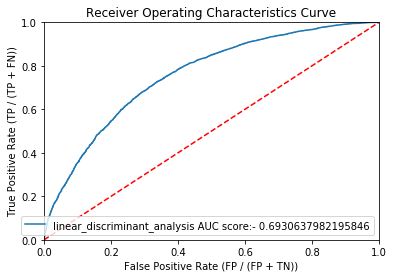

In [74]:
generate_classifier_report(clf,pred,clf.predict_proba(X_test)[:,1],name="linear_discriminant_analysis")

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Time to train 10 trees:- 
2.48071026802063
OOB score for 10 trees:- 
0.7127726247179744
Classifier report for 10 trees:- 
Model stats for random_forest_classifier_10_trees:
Accuracy:
0.7388724035608308
Confusion matrix:
0.7388724035608308
Mathews correlation coefficient:
0.4814238857555637
Classification report:
              precision    recall  f1-score   support

         0.0       0.71      0.80      0.75      8088
         1.0       0.77      0.68      0.72      8088

   micro avg       0.74      0.74      0.74     16176
   macro avg       0.74      0.74      0.74     16176
weighted avg       0.74      0.74      0.74     16176



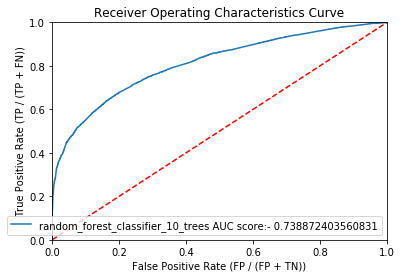

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Time to train 20 trees:- 
4.089144706726074
OOB score for 20 trees:- 
0.7432783905740787
Classifier report for 20 trees:- 
Model stats for random_forest_classifier_20_trees:
Accuracy:
0.7563674579624134
Confusion matrix:
0.7563674579624134
Mathews correlation coefficient:
0.5168207416619869
Classification report:
              precision    recall  f1-score   support

         0.0       0.73      0.82      0.77      8088
         1.0       0.79      0.69      0.74      8088

   micro avg       0.76      0.76      0.76     16176
   macro avg       0.76      0.76      0.76     16176
weighted avg       0.76      0.76      0.76     16176



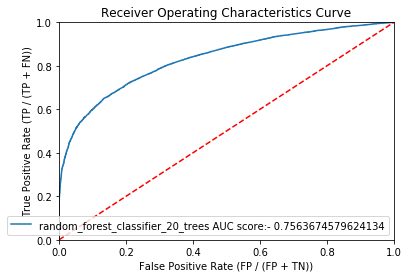

Time to train 30 trees:- 
7.007411956787109
OOB score for 30 trees:- 
0.7574266733517172
Classifier report for 30 trees:- 
Model stats for random_forest_classifier_30_trees:
Accuracy:
0.7639713155291791
Confusion matrix:
0.7639713155291791
Mathews correlation coefficient:
0.5327671686196485
Classification report:
              precision    recall  f1-score   support

         0.0       0.73      0.83      0.78      8088
         1.0       0.80      0.70      0.75      8088

   micro avg       0.76      0.76      0.76     16176
   macro avg       0.77      0.76      0.76     16176
weighted avg       0.77      0.76      0.76     16176



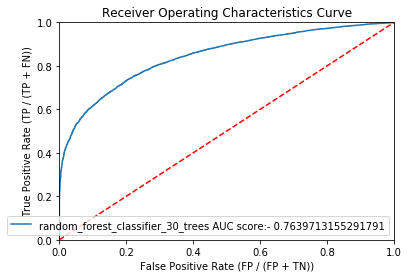

Time to train 40 trees:- 
9.549437999725342
OOB score for 40 trees:- 
0.7683003258962146
Classifier report for 40 trees:- 
Model stats for random_forest_classifier_40_trees:
Accuracy:
0.7687932739861523
Confusion matrix:
0.7687932739861523
Mathews correlation coefficient:
0.5428732244947271
Classification report:
              precision    recall  f1-score   support

         0.0       0.74      0.84      0.78      8088
         1.0       0.81      0.70      0.75      8088

   micro avg       0.77      0.77      0.77     16176
   macro avg       0.77      0.77      0.77     16176
weighted avg       0.77      0.77      0.77     16176



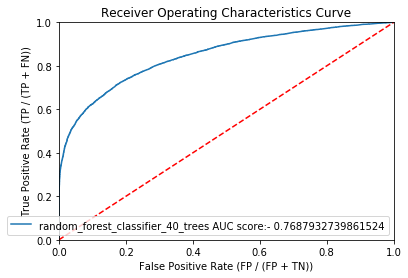

Time to train 50 trees:- 
10.138611078262329
OOB score for 50 trees:- 
0.7729850839809476
Classifier report for 50 trees:- 
Model stats for random_forest_classifier_50_trees:
Accuracy:
0.7679896142433235
Confusion matrix:
0.7679896142433235
Mathews correlation coefficient:
0.5404572178601961
Classification report:
              precision    recall  f1-score   support

         0.0       0.74      0.83      0.78      8088
         1.0       0.81      0.70      0.75      8088

   micro avg       0.77      0.77      0.77     16176
   macro avg       0.77      0.77      0.77     16176
weighted avg       0.77      0.77      0.77     16176



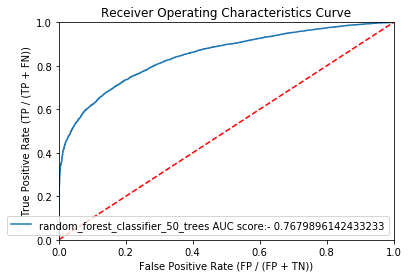

Time to train 100 trees:- 
19.44663715362549
OOB score for 100 trees:- 
0.7845011281022812
Classifier report for 100 trees:- 
Model stats for random_forest_classifier_100_trees:
Accuracy:
0.7716369930761622
Confusion matrix:
0.7716369930761622
Mathews correlation coefficient:
0.5486939232878901
Classification report:
              precision    recall  f1-score   support

         0.0       0.74      0.84      0.79      8088
         1.0       0.82      0.70      0.75      8088

   micro avg       0.77      0.77      0.77     16176
   macro avg       0.78      0.77      0.77     16176
weighted avg       0.78      0.77      0.77     16176



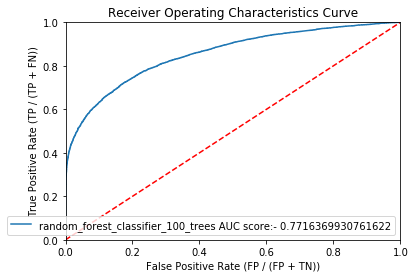

Time to train 150 trees:- 
28.575037002563477
OOB score for 150 trees:- 
0.7894209074956129
Classifier report for 150 trees:- 
Model stats for random_forest_classifier_150_trees:
Accuracy:
0.7750989119683481
Confusion matrix:
0.7750989119683481
Mathews correlation coefficient:
0.5560262444583495
Classification report:
              precision    recall  f1-score   support

         0.0       0.74      0.85      0.79      8088
         1.0       0.82      0.70      0.76      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.78      0.78      0.77     16176
weighted avg       0.78      0.78      0.77     16176



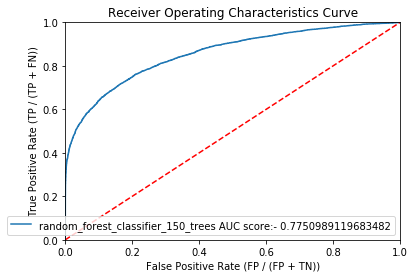

Time to train 200 trees:- 
39.131317138671875
OOB score for 200 trees:- 
0.7913324141388819
Classifier report for 200 trees:- 
Model stats for random_forest_classifier_200_trees:
Accuracy:
0.7726879327398615
Confusion matrix:
0.7726879327398615
Mathews correlation coefficient:
0.5512643146535188
Classification report:
              precision    recall  f1-score   support

         0.0       0.74      0.85      0.79      8088
         1.0       0.82      0.70      0.75      8088

   micro avg       0.77      0.77      0.77     16176
   macro avg       0.78      0.77      0.77     16176
weighted avg       0.78      0.77      0.77     16176



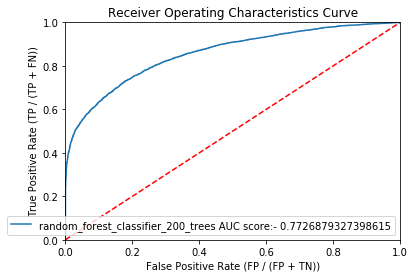

Time to train 250 trees:- 
49.258918046951294
OOB score for 250 trees:- 
0.792711205815994
Classifier report for 250 trees:- 
Model stats for random_forest_classifier_250_trees:
Accuracy:
0.7770153313550939
Confusion matrix:
0.7770153313550939
Mathews correlation coefficient:
0.5598690977041709
Classification report:
              precision    recall  f1-score   support

         0.0       0.74      0.85      0.79      8088
         1.0       0.82      0.70      0.76      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.78      0.78      0.78     16176
weighted avg       0.78      0.78      0.78     16176



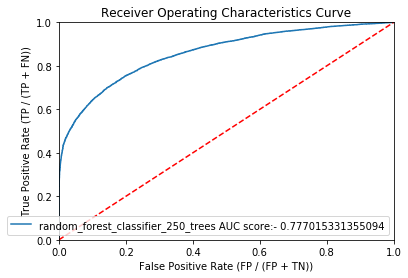

Time to train 300 trees:- 
57.467854261398315
OOB score for 300 trees:- 
0.7930245675607922
Classifier report for 300 trees:- 
Model stats for random_forest_classifier_300_trees:
Accuracy:
0.7767680514342236
Confusion matrix:
0.7767680514342236
Mathews correlation coefficient:
0.5595746449193142
Classification report:
              precision    recall  f1-score   support

         0.0       0.74      0.85      0.79      8088
         1.0       0.82      0.70      0.76      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.78      0.78      0.78     16176
weighted avg       0.78      0.78      0.78     16176



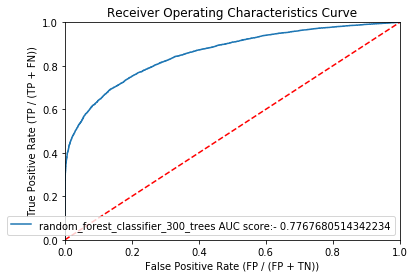

Time to train 400 trees:- 
84.59266209602356
OOB score for 400 trees:- 
0.794779393331662
Classifier report for 400 trees:- 
Model stats for random_forest_classifier_400_trees:
Accuracy:
0.7758407517309595
Confusion matrix:
0.7758407517309595
Mathews correlation coefficient:
0.5578557236779048
Classification report:
              precision    recall  f1-score   support

         0.0       0.74      0.85      0.79      8088
         1.0       0.82      0.70      0.76      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.78      0.78      0.77     16176
weighted avg       0.78      0.78      0.77     16176



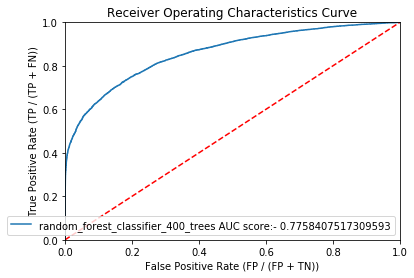

Time to train 500 trees:- 
99.08126020431519
OOB score for 500 trees:- 
0.794622712459263
Classifier report for 500 trees:- 
Model stats for random_forest_classifier_500_trees:
Accuracy:
0.7765207715133531
Confusion matrix:
0.7765207715133531
Mathews correlation coefficient:
0.5591577859548164
Classification report:
              precision    recall  f1-score   support

         0.0       0.74      0.85      0.79      8088
         1.0       0.82      0.70      0.76      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.78      0.78      0.78     16176
weighted avg       0.78      0.78      0.78     16176



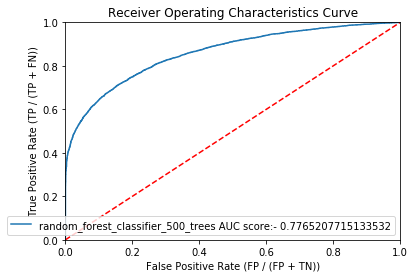

Time to train 750 trees:- 
143.11327004432678
OOB score for 750 trees:- 
0.7952494359488593
Classifier report for 750 trees:- 
Model stats for random_forest_classifier_750_trees:
Accuracy:
0.7762734915924827
Confusion matrix:
0.7762734915924827
Mathews correlation coefficient:
0.5583494919633498
Classification report:
              precision    recall  f1-score   support

         0.0       0.74      0.85      0.79      8088
         1.0       0.82      0.70      0.76      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.78      0.78      0.78     16176
weighted avg       0.78      0.78      0.78     16176



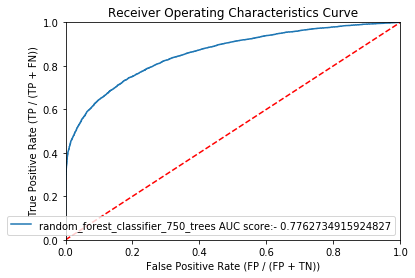

Time to train 1000 trees:- 
190.65335988998413
OOB score for 1000 trees:- 
0.7958761594384558
Classifier report for 1000 trees:- 
Model stats for random_forest_classifier_1000_trees:
Accuracy:
0.7781280909990109
Confusion matrix:
0.7781280909990109
Mathews correlation coefficient:
0.5624710545285968
Classification report:
              precision    recall  f1-score   support

         0.0       0.74      0.85      0.79      8088
         1.0       0.83      0.70      0.76      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.78      0.78      0.78     16176
weighted avg       0.78      0.78      0.78     16176



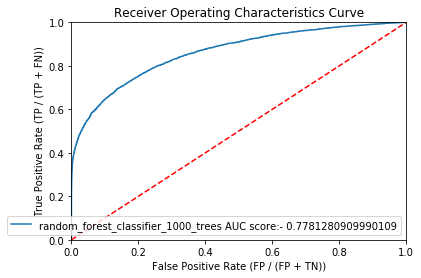

In [75]:
#Have to use Bayesian Optimization to find better set of hyperparameters
#best performance value found 400
no_of_trees = [10,20,30,40,50,100,150,200,250,300,400,500,750,1000]
error = []
for noft in no_of_trees:
    starttime = time.time()
    classifier = RandomForestClassifier(n_estimators=noft,max_depth=25,oob_score=True)
    classifier.fit(X_train,y_train)
    endtime = time.time()
    print("Time to train " + str(noft) + " trees:- ")
    print(endtime - starttime)
    error.append(classifier.oob_score_)
    prediction = classifier.predict(X_test)
    print("OOB score for " + str(noft) + " trees:- ")
    print(classifier.oob_score_)
    print("Classifier report for " + str(noft) + " trees:- ")
    generate_classifier_report(classifier,prediction,classifier.predict_proba(X_test)[:,1],"random_forest_classifier_" + str(noft) + "_trees")
    #get_rf_confidence_interval(classifier,prediction,"random_forest_classifier_" + str(noft) + "_trees")

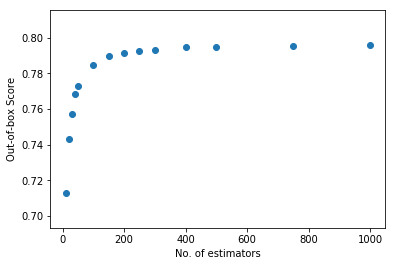

In [76]:
plt.scatter(no_of_trees,error)
plt.xlabel("No. of estimators")
plt.ylabel("Out-of-box Score")
plt.savefig("error_vs_nestimators.jpg")

In [77]:
def get_rf_confidence_interval(classifier,pred,name):
    plt.scatter(y_test, pred)
    plt.plot([5, 45], [5, 45], 'k--')
    plt.xlabel('Reported MPG')
    plt.ylabel('Predicted MPG')
    plt.axis((0,1,0,1))
    plt.show()
    var = forestci.random_forest_error(classifier, X_train,X_test)
    plt.errorbar(y_test, pred, yerr=np.sqrt(var), fmt='o')
    plt.plot([5, 45], [5, 45], 'k--')
    plt.xlabel('Reported MPG')
    plt.ylabel('Predicted MPG')
    plt.axis((0,1,0,1))
    plt.savefig(name + "_confidence_interval")
    plt.show()

In [78]:
starttime = time.time()
boosting = XGBClassifier(alpha=1,eval_metric='logloss',max_depth=25,n_estimators=400,verbosity=2)
boosting.fit(X_train,y_train)
endtime = time.time()
print("Time to train XGBClassifier :- ")
print(endtime - starttime)

Time to train XGBClassifier :- 
1450.7840220928192


In [79]:
pred = boosting.predict(X_test)

In [80]:
cross_validation_score(boosting,X,y,cv=5)

0.7736000000000001

Model stats for xgb_classifier:
Accuracy:
0.793026706231454
Confusion matrix:
0.793026706231454
Mathews correlation coefficient:
0.5906955966230376
Classification report:
              precision    recall  f1-score   support

         0.0       0.76      0.86      0.81      8088
         1.0       0.83      0.73      0.78      8088

   micro avg       0.79      0.79      0.79     16176
   macro avg       0.80      0.79      0.79     16176
weighted avg       0.80      0.79      0.79     16176



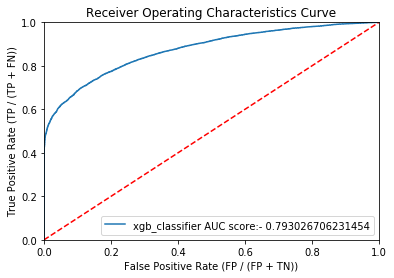

In [81]:
generate_classifier_report(boosting,pred,boosting.predict_proba(X_test)[:,1],'xgb_classifier')

In [82]:
starttime = time.time()
clf = lgb.LGBMClassifier(boosting_type='gbdt',objective='binary',n_estimators=400,max_depth=25)
clf.fit(X_train,y_train)
endtime = time.time()
print("Time to train LightGBM classifier:- ")
print(endtime - starttime)

Time to train LightGBM classifier:- 
102.90613508224487


In [83]:
pred = clf.predict(X_test)

In [84]:
cross_validation_score(clf,X_train,y_train,cv=5)

0.768826297111967

Model stats for lgb_classifier:
Accuracy:
0.7969831849653808
Confusion matrix:
0.7969831849653808
Mathews correlation coefficient:
0.5991341082534978
Classification report:
              precision    recall  f1-score   support

         0.0       0.76      0.86      0.81      8088
         1.0       0.84      0.73      0.78      8088

   micro avg       0.80      0.80      0.80     16176
   macro avg       0.80      0.80      0.80     16176
weighted avg       0.80      0.80      0.80     16176



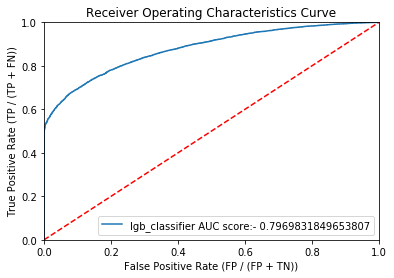

In [85]:
generate_classifier_report(clf,pred,clf.predict_proba(X_test)[:,1],'lgb_classifier')

In [ ]:
X = tf.placeholder(shape=[None,222],dtype=tf.float32)
y = tf.placeholder(shape=[None],dtype=tf.int64)

In [ ]:
weights = {
    'W1': tf.Variable(tf.truncated_normal(shape=[222,140])),
    'W2': tf.Variable(tf.truncated_normal(shape=[140,70])),
    'W3': tf.Variable(tf.truncated_normal(shape=[70,27])),
    'W4': tf.Variable(tf.truncated_normal(shape=[27,1]))
}
biases = {
    'b1': tf.Variable(tf.truncated_normal(shape=[140])),
    'b2': tf.Variable(tf.truncated_normal(shape=[70])),
    'b3': tf.Variable(tf.truncated_normal(shape=[27])),
    'b4': tf.Variable(tf.truncated_normal(shape=[1]))
}

In [ ]:
def get_model(X,weights,biases):
    op1 = tf.add(tf.matmul(X,weights['W1']),biases['b1'])
    relu_op1 = tf.nn.relu(op1) 
    op2 = tf.add(tf.matmul(relu_op1,weights['W2']),biases['b2'])
    relu_op2 = tf.nn.relu(op2)
    op3 = tf.add(tf.matmul(relu_op2,weights['W3']),biases['b3'])
    relu_op3 = tf.nn.relu(op3)
    op4 = tf.add(tf.matmul(relu_op3,weights['W4']),biases['b4'])
    return op4

In [ ]:
pred = get_model(X,weights,biases)
optimizer = tf.train.AdamOptimizer(learning_rate=0.)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=pred))
train_step = optimizer.minimize(loss)

In [ ]:
#Improve accuracy here 
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(0,10):
        cost = 0
        total_batch = X_train.shape[0]/100
        X_batches = np.array_split(X_train,total_batch)
        y_batches = np.array_split(y_train,total_batch)
        for j in range(0,int(total_batch)):
            g,c = sess.run([train_step,loss],feed_dict={
                X: X_batches[j],
                y: y_batches[j]
            })
            cost = cost + c/total_batch
        print("Epoch:- " + str(i) + " Cost:- " + str(cost))
    correct_prediction = tf.equal(tf.argmax(pred,1),y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))
    print("Accuracy:- " + str(accuracy.eval({X: X_test,y: y_test})))